In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

## Data Prep

In [41]:
df = pd.read_excel('Analysis_Data.xlsx', sheet_name='Drilling Cost')
df.columns = ['Date', 'Crude_Oil_Drill_Cost', 'Natural_Gas_Drill_Cost', 'Dry_Well_Drill_Cost',
               'Arithmetic_Return_Crude_Oil', 'Arithmetic_Return_Natural_Gas', 'Arithmetic_Return_Dry_Well']

df = df.iloc[2:] # Remove top 2 rows
df.replace('.', np.nan, inplace=True)

# cast date as dt and filter
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 1990) & (df['Date'].dt.year <= 2006)]

# calculate avg costs and returns
df['AVG_Cost'] = df.iloc[:,1:4].mean(axis=1)
df['AVG_Return'] = df.iloc[:,4:7].mean(axis=1)

df.head()

C:\Users\Sterling Hayden\AppData\Local\Temp\ipykernel_2772\174545402.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('.', np.nan, inplace=True)


,Date,Crude_Oil_Drill_Cost,Natural_Gas_Drill_Cost,Dry_Well_Drill_Cost,Arithmetic_Return_Crude_Oil,Arithmetic_Return_Natural_Gas,Arithmetic_Return_Dry_Well,AVG_Cost,AVG_Return
32,1990-06-30,321.8,471.3,367.5,0.139922,0.029489,0.034046,386.866667,0.067819
33,1991-06-30,346.9,506.6,441.2,0.077999,0.074899,0.200544,431.566667,0.117814
34,1992-06-30,362.3,426.1,357.6,0.044393,-0.158902,-0.189483,382.000000,-0.101331
35,1993-06-30,356.6,521.2,387.7,-0.015733,0.223187,0.084172,421.833333,0.097209
36,1994-06-30,409.5,535.1,491.5,0.148345,0.026669,0.267733,478.700000,0.147582


## Checking Normality 

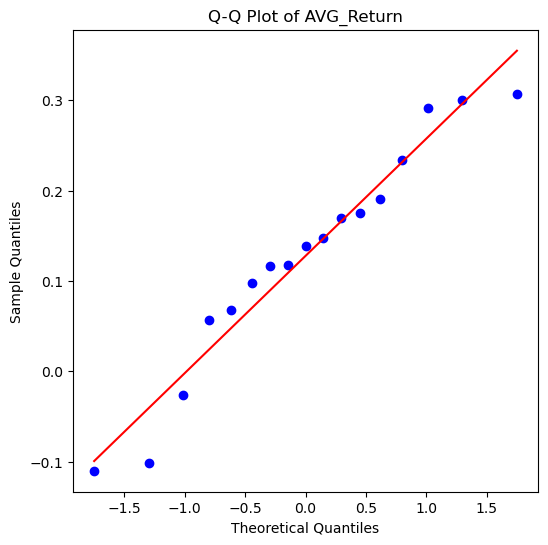

In [45]:
# Create a Q-Q plot
fig, ax = plt.subplots(figsize=(6, 6))  # Set figure size
stats.probplot(df['AVG_Return'], dist="norm", plot=ax)

# Customize title and labels
ax.set_title("Q-Q Plot of AVG_Return")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")

plt.show()


In [47]:
stat, p = stats.shapiro(df['AVG_Return'].dropna())
print(f"Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p:.4f}")

Shapiro-Wilk Test: Statistic=0.9440, p-value=0.3689


Seems like arithmetic changes from one year to the next from 2006 to 2012 **do not** follow a Normal 
distribution. Assuming that from 2006 to 2012 changes were relatively consistent in their distribution compaired to past years.

## Kernel Density  Estimate